## Intro
This is my take on the siamese neural network snack detection exercise I was presented as an interview exercise - This turned out to be an interesting topic I would like to explore further, and see if it applies to the world of audio plagiarism.

## Helpful resources

### High level refresher
 * https://www.youtube.com/watch?v=6jfw8MuKwpI
 * https://www.youtube.com/watch?v=d2XB5-tuCWU

### Digging Deeper
 * https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf
 * https://arxiv.org/abs/1503.03832

### *Implementation pointers
 * https://www.kaggle.com/code/hirotaka0122/triplet-loss-with-pytorch
 * https://datahacker.rs/019-siamese-network-in-pytorch-with-application-to-face-similarity/


*watch out, code quality is low, these are good only as primers



In [ ]:
!pip install datasets

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps

import datasets
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# I. Data Pre-processing, Storage




 * Structure the data as image folders for smoother integration with PyTorch
 * Write folders to a public GCS bucket created for the purpose of this exercise
 * Setup a mount from the bucket to this colab



In [ ]:
from pathlib import Path
from datasets import load_dataset
from PIL import Image

all_the_snacks = load_dataset('Matthijs/snacks')

In [ ]:
import os
from pathlib import Path
from datasets import DatasetDict
import uuid

def create_image_folder(root, hf_dataset, exist_ok=False):
  for split in hf_dataset:
    for label in hf_dataset[split].features['label'].names:
      os.makedirs(Path(root, split, label), exist_ok=exist_ok)

    label_map = hf_dataset[split].features['label'].int2str

    for record in hf_dataset[split]:
      record['image'].save(Path(root, split, label_map(record['label']), f'{uuid.uuid4()}.jpeg'))

create_image_folder('my_snacks', all_the_snacks, exist_ok=True)

# Note: this only needed to be ran to populate GCS. In real life we'd want an idempotent process that can be used
# to reload and update data as needed.. Not for today :)

I am keeping it simple here and run bash commands directly through colab in order to setup fuse and mount the bucket. Given the size of the dataset, I would rather keep the data local and speed up the training, but this can be uncommented to enable the GCS mount.

In [ ]:
#!mkdir my_snacks_gcs

In [ ]:
#!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list

In [ ]:
#!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -

In [ ]:
#!apt -qq update

In [ ]:
#!apt -qq install gcsfuse

In [ ]:
#!gcsfuse --implicit-dirs great_siamese_snacks my_snacks_gcs

The task requires a custom Pytorch Dataset. Note this dataset has two usages:
 * Provide Triplets to feed the model at each training step, allowing to compute triplet loss
 * Provide pairs at validation and testing time to evaluate the model on the image verification task

In [ ]:
import random
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.datasets as datasets

# Defining a custom dataset that makes image folder compatible with triplet loss
# TODO: Extend image folder instead of composing
# TODO: Add some image validity checks/clean up the dataset

class SiameseSamplerDataset(Dataset):
    def __init__(self, root, transform=None, test=False):
        self.image_folder = datasets.ImageFolder(root=root)
        self.idx_to_class = {v:k for k, v in self.image_folder.class_to_idx.items()}
        self.transform = transform
        self.test = test


    def _get_different_sample(self, anchor_idx, is_positive):
      #TODO: Pytorch dataset doesn't support filtering..
      # consider turning the list of records into a dict of lists and use that to sample
      # to reduce the training overhead

      #TODO: Random triplet selection is a somewhat naive approach: https://www.youtube.com/watch?v=d2XB5-tuCWU
      while True:
        candidate_idx = random.randint(0, len(self.image_folder) - 1)
        candidate_sample = self.image_folder.imgs[candidate_idx]
        is_label_match = self.image_folder.imgs[anchor_idx][1] == candidate_sample[1]

        if not candidate_idx == anchor_idx and (is_label_match == is_positive):
          return candidate_sample



    def __getitem__(self, index):
        anchor = self.image_folder[index]

        positive_sample = self._get_different_sample(index, is_positive=True)
        negative_sample = self._get_different_sample(index, is_positive=False)

        # TODO: check this is redudant

        anchor_img = anchor[0]
        pos_img = Image.open(positive_sample[0])
        neg_img = Image.open(negative_sample[0])

        anchor_img = anchor_img.convert("L")
        pos_img = pos_img.convert("L")
        neg_img = neg_img.convert("L")

        if self.transform:
            anchor_img = self.transform(anchor_img)
            pos_img = self.transform(pos_img)
            neg_img = self.transform(neg_img)

        anchor_label = anchor[1]

        if self.test:
          candidate_img, is_match = random.choice([(neg_img, False), (pos_img, True)])
          return anchor_img, candidate_img, is_match

        return anchor_img, pos_img, neg_img, anchor_label

    def __len__(self):
        return len(self.image_folder.imgs)

In [ ]:
import matplotlib.pyplot as plt

# Showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [ ]:
from pathlib import Path

train_transform = transforms.Compose([transforms.Resize((224,224)), # Used to just resize to 100
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
                                    ])

gcs_root = Path('.', 'my_snacks_gcs', 'my_snacks')
local_root = Path('.', 'my_snacks')

train_dataset = SiameseSamplerDataset(Path(local_root, 'train'), train_transform)
val_dataset = SiameseSamplerDataset(Path(local_root, 'validation'), train_transform, test=True)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=2)

4


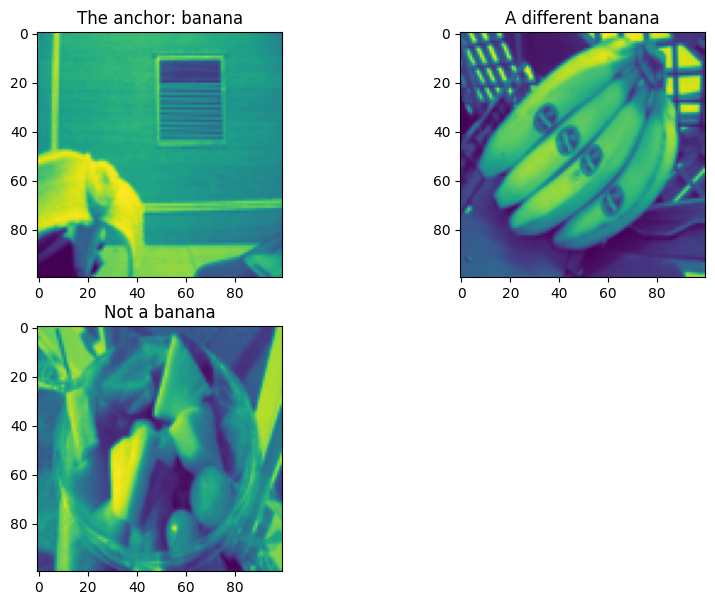

In [ ]:
# Let's take a quick look at a preprocessed batch
def peek(data: SiameseSamplerDataset):
  loader = DataLoader(data,
                          shuffle=True,
                          num_workers=2,
                          batch_size=1)

  batch = next(iter(loader))
  fig = plt.figure(figsize=(10, 7))

  rows = 2
  columns = 2

  label = data.idx_to_class[batch[3].numpy()[0]]
  fig.add_subplot(rows, columns, 1)
  plt.imshow(batch[0][0].numpy().transpose(1, 2, 0))
  plt.title(f"The anchor: {label}")
  fig.add_subplot(rows, columns, 2)
  plt.imshow(batch[1][0].numpy().transpose(1, 2, 0))
  plt.title(f"A different {label}")
  fig.add_subplot(rows, columns, 3)
  plt.imshow(batch[2][0].numpy().transpose(1, 2, 0))
  plt.title(f"Not a {label}")

peek(train_dataset)



## II. Defining the Siamese Network


One noticeable difference between implementations is using the network to generate embeddings and report on similarity scores, vs adding a single logistic unit/softmax at the end and output the answer to "Are these two things the same", as suggested in the original paper: https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf

In this case, we are optimizing for accuracy and using a dataset with class labels as targets. We are reducing the space to a classification problem and we should optimize accordingly.

That original paper however, uses cross entropy loss rather than triplet loss. What we are trying to achieve here within the constraints of the exercise is much more similar to this: https://arxiv.org/pdf/1503.03832.pdf

In [ ]:
# Create the Siamese Neural Network
# TODO: See what happens with a fine tuned facenet instead of starting from scratch

class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        self.fc = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256,2)
        )


    def forward(self, image):
        output = self.cnn(image)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output


In [ ]:
import torch.nn as nn

model = SiameseNetwork()
criterion = nn.TripletMarginLoss(margin=1.0, p=2)
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
epochs = 10
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max = np.ceil(len(train_loader.dataset) / batch_size) * epochs,
    eta_min = 1e-5
)

In [ ]:
from sklearn.metrics import accuracy_score

# I will be looking at accuracy during evaluation, that being said this doesn't give the full color on the similiarity scores we are generating.
# TODO: Explore other metrics, take a look at what the literature says
def calculate_metric(y, y_pred):
    metric = accuracy_score(y, y_pred)
    return metric

def calculate_distance(embedding_a, embedding_b):
  return float(np.linalg.norm(embedding_a - embedding_b))

In [ ]:
# TODO: Tune the distance threshold
# TODO: store a reference embedding for each snack type instead of running inference twice

def is_same_snack(candidate, identity, threshold=0.8):
    distance = calculate_distance(candidate, identity)
    return distance < threshold

In [ ]:
from matplotlib.legend import StepPatch
from tqdm import tqdm

def train_one_epoch(dataloader, model, optimizer, scheduler):
  model.train()

  y_pred_list = []
  y_list = []
  running_loss = []
  steps = []

  for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
    optimizer.zero_grad()

    with torch.set_grad_enabled(True):
      A_embd = model(anchor_img)
      p_embd = model(positive_img)
      n_embd = model(negative_img)

      loss = criterion(A_embd, p_embd, n_embd)
      loss.backward()
      optimizer.step()

      running_loss.append(loss.cpu().detach().numpy())

      A_embd = A_embd.detach().numpy()
      p_embd = p_embd.detach().numpy()
      n_embd = n_embd.detach().numpy()

      y_pred_list += [is_same_snack(p_embd, A_embd), is_same_snack(n_embd, A_embd)]
      y_list += [True, False]


    if step % 10 == 0 :
      print(f"Loss: {loss.item()}\n")

  return calculate_metric(y_list, y_pred_list), np.mean(running_loss)


In [ ]:
train_one_epoch(train_loader, model, optimizer, scheduler)

In [ ]:
def validate_one_epoch(dataloader, model):
    model.eval()

    y_pred_list = []
    y_list = []

    for batch in dataloader:
        anchor_img, candidate_img, y = batch

        with torch.no_grad():
            y_pred = is_same_snack(model(candidate_img), model(anchor_img))
            y_pred_list.append(y_pred)
            y_list.extend(y)

    return calculate_metric(y_list, y_pred_list)

val_accuracy = validate_one_epoch(val_loader, model)
val_accuracy

0.49109947643979057

In [ ]:
def fit(model, optimizer, scheduler, train_dataloader, epochs, valid_dataloader=None):
    acc_list = []
    loss_list = []
    val_acc_list = []

    for epoch in range(epochs):
        acc, loss = train_one_epoch(train_loader, model, optimizer, scheduler)

        if valid_dataloader:
            val_acc = validate_one_epoch(val_loader, model)

        acc_list.append(acc)
        loss_list.append(loss)

        if valid_dataloader:
            val_acc_list.append(val_acc)

    return acc_list, loss_list, val_acc_list, val_loss_list, model

acc_list, loss_list, val_acc_list, model = fit(model, optimizer, scheduler, train_loader, 1, val_loader)

Training:   0%|          | 1/1210 [00:01<25:45,  1.28s/it]

Epoch: 0
Loss: 1.011501431465149



Training:   1%|          | 11/1210 [00:04<05:14,  3.82it/s]

Epoch: 0
Loss: 0.9894562363624573



Training:   2%|▏         | 21/1210 [00:06<04:54,  4.03it/s]

Epoch: 0
Loss: 1.008534550666809



Training:   3%|▎         | 31/1210 [00:09<04:49,  4.08it/s]

Epoch: 0
Loss: 1.0224710702896118



Training:   3%|▎         | 41/1210 [00:11<04:50,  4.02it/s]

Epoch: 0
Loss: 1.0006190538406372



Training:   4%|▍         | 51/1210 [00:17<09:33,  2.02it/s]

Epoch: 0
Loss: 1.0322648286819458



Training:   5%|▌         | 61/1210 [00:19<04:47,  4.00it/s]

Epoch: 0
Loss: 0.9896819591522217



Training:   6%|▌         | 71/1210 [00:21<04:32,  4.19it/s]

Epoch: 0
Loss: 1.0060951709747314



Training:   7%|▋         | 81/1210 [00:24<04:31,  4.15it/s]

Epoch: 0
Loss: 0.9519314765930176



Training:   8%|▊         | 91/1210 [00:27<06:37,  2.82it/s]

Epoch: 0
Loss: 1.0484998226165771



Training:   8%|▊         | 101/1210 [00:30<05:10,  3.58it/s]

Epoch: 0
Loss: 0.9817898273468018



Training:   9%|▉         | 111/1210 [00:33<04:23,  4.18it/s]

Epoch: 0
Loss: 1.0731652975082397



Training:  10%|█         | 121/1210 [00:35<04:17,  4.23it/s]

Epoch: 0
Loss: 1.194796085357666



Training:  11%|█         | 131/1210 [00:37<04:15,  4.22it/s]

Epoch: 0
Loss: 1.1324745416641235



Training:  12%|█▏        | 141/1210 [00:40<05:28,  3.25it/s]

Epoch: 0
Loss: 0.9780849814414978



Training:  12%|█▏        | 151/1210 [00:44<05:31,  3.19it/s]

Epoch: 0
Loss: 0.7993800640106201



Training:  13%|█▎        | 161/1210 [00:46<04:09,  4.20it/s]

Epoch: 0
Loss: 1.1283183097839355



Training:  14%|█▍        | 171/1210 [00:48<04:03,  4.26it/s]

Epoch: 0
Loss: 0.984487771987915



Training:  15%|█▍        | 181/1210 [00:51<04:08,  4.15it/s]

Epoch: 0
Loss: 0.9579302668571472



Training:  16%|█▌        | 191/1210 [00:55<09:38,  1.76it/s]

Epoch: 0
Loss: 0.9442852139472961



Training:  17%|█▋        | 201/1210 [00:59<04:51,  3.47it/s]

Epoch: 0
Loss: 1.1705846786499023



Training:  17%|█▋        | 211/1210 [01:02<04:08,  4.02it/s]

Epoch: 0
Loss: 0.7938234806060791



Training:  18%|█▊        | 221/1210 [01:04<04:04,  4.05it/s]

Epoch: 0
Loss: 1.0026756525039673



Training:  19%|█▉        | 231/1210 [01:07<03:59,  4.09it/s]

Epoch: 0
Loss: 0.8848370313644409



Training:  20%|█▉        | 241/1210 [01:10<06:14,  2.59it/s]

Epoch: 0
Loss: 1.0483263731002808



Training:  21%|██        | 251/1210 [01:13<04:07,  3.87it/s]

Epoch: 0
Loss: 0.8563787341117859



Training:  22%|██▏       | 261/1210 [01:16<03:54,  4.05it/s]

Epoch: 0
Loss: 0.7480975389480591



Training:  22%|██▏       | 271/1210 [01:18<03:46,  4.14it/s]

Epoch: 0
Loss: 0.6200852990150452



Training:  23%|██▎       | 281/1210 [01:21<03:50,  4.03it/s]

Epoch: 0
Loss: 0.6523107290267944



Training:  24%|██▍       | 291/1210 [01:24<05:46,  2.65it/s]

Epoch: 0
Loss: 0.8723012208938599



Training:  25%|██▍       | 301/1210 [01:27<04:01,  3.76it/s]

Epoch: 0
Loss: 0.7467724680900574



Training:  26%|██▌       | 311/1210 [01:30<03:41,  4.07it/s]

Epoch: 0
Loss: 1.2479071617126465



Training:  27%|██▋       | 321/1210 [01:32<03:42,  4.00it/s]

Epoch: 0
Loss: 0.984778106212616



Training:  27%|██▋       | 331/1210 [01:35<03:36,  4.05it/s]

Epoch: 0
Loss: 0.8738481402397156



Training:  28%|██▊       | 341/1210 [01:38<05:21,  2.70it/s]

Epoch: 0
Loss: 0.9658666849136353



Training:  29%|██▉       | 351/1210 [01:41<03:57,  3.61it/s]

Epoch: 0
Loss: 0.9629693031311035



Training:  30%|██▉       | 361/1210 [01:44<03:30,  4.04it/s]

Epoch: 0
Loss: 1.027348518371582



Training:  31%|███       | 371/1210 [01:46<03:28,  4.02it/s]

Epoch: 0
Loss: 0.9346840977668762



Training:  31%|███▏      | 381/1210 [01:49<03:23,  4.06it/s]

Epoch: 0
Loss: 0.9220830202102661



Training:  32%|███▏      | 391/1210 [01:52<05:06,  2.68it/s]

Epoch: 0
Loss: 1.073441982269287



Training:  33%|███▎      | 401/1210 [01:55<03:57,  3.40it/s]

Epoch: 0
Loss: 0.965587854385376



Training:  34%|███▍      | 411/1210 [01:58<03:17,  4.06it/s]

Epoch: 0
Loss: 0.804539680480957



Training:  35%|███▍      | 421/1210 [02:00<03:15,  4.04it/s]

Epoch: 0
Loss: 0.9119645357131958



Training:  36%|███▌      | 431/1210 [02:03<03:09,  4.10it/s]

Epoch: 0
Loss: 0.9137387871742249



Training:  36%|███▋      | 441/1210 [02:07<08:19,  1.54it/s]

Epoch: 0
Loss: 1.073771595954895



Training:  37%|███▋      | 451/1210 [02:11<03:25,  3.69it/s]

Epoch: 0
Loss: 0.8448061347007751



Training:  38%|███▊      | 461/1210 [02:13<03:03,  4.08it/s]

Epoch: 0
Loss: 0.9917412400245667



Training:  39%|███▉      | 471/1210 [02:15<03:04,  4.01it/s]

Epoch: 0
Loss: 0.9463350772857666



Training:  40%|███▉      | 481/1210 [02:18<03:01,  4.02it/s]

Epoch: 0
Loss: 0.9499550461769104



Training:  41%|████      | 491/1210 [02:21<04:24,  2.72it/s]

Epoch: 0
Loss: 0.9555813670158386



Training:  41%|████▏     | 501/1210 [02:24<03:05,  3.83it/s]

Epoch: 0
Loss: 1.0002596378326416



Training:  42%|████▏     | 511/1210 [02:28<04:25,  2.63it/s]

Epoch: 0
Loss: 0.9038384556770325



Training:  43%|████▎     | 521/1210 [02:33<05:49,  1.97it/s]

Epoch: 0
Loss: 0.8133660554885864



Training:  44%|████▍     | 531/1210 [02:39<05:32,  2.04it/s]

Epoch: 0
Loss: 0.767876386642456



Training:  45%|████▍     | 541/1210 [02:42<03:42,  3.01it/s]

Epoch: 0
Loss: 1.043287992477417



Training:  46%|████▌     | 551/1210 [02:46<03:38,  3.02it/s]

Epoch: 0
Loss: 0.952438235282898



Training:  46%|████▋     | 561/1210 [02:51<07:06,  1.52it/s]

Epoch: 0
Loss: 1.0044991970062256



Training:  47%|████▋     | 571/1210 [02:55<02:59,  3.57it/s]

Epoch: 0
Loss: 0.9211862087249756



Training:  48%|████▊     | 581/1210 [02:57<02:40,  3.92it/s]

Epoch: 0
Loss: 1.0266680717468262



Training:  49%|████▉     | 591/1210 [03:01<04:35,  2.24it/s]

Epoch: 0
Loss: 0.895646333694458



Training:  50%|████▉     | 601/1210 [03:05<05:33,  1.83it/s]

Epoch: 0
Loss: 1.0145280361175537



Training:  50%|█████     | 611/1210 [03:10<03:45,  2.65it/s]

Epoch: 0
Loss: 0.9661678671836853



Training:  51%|█████▏    | 621/1210 [03:14<03:57,  2.48it/s]

Epoch: 0
Loss: 0.943572998046875



Training:  52%|█████▏    | 631/1210 [03:18<05:29,  1.76it/s]

Epoch: 0
Loss: 1.1014097929000854



Training:  53%|█████▎    | 641/1210 [03:22<02:49,  3.36it/s]

Epoch: 0
Loss: 1.1180812120437622



Training:  54%|█████▍    | 651/1210 [03:25<03:35,  2.59it/s]

Epoch: 0
Loss: 0.8823326230049133



Training:  55%|█████▍    | 661/1210 [03:28<02:24,  3.79it/s]

Epoch: 0
Loss: 0.988349437713623



Training:  55%|█████▌    | 671/1210 [03:31<02:42,  3.31it/s]

Epoch: 0
Loss: 0.9308637380599976



Training:  56%|█████▋    | 681/1210 [03:35<03:27,  2.55it/s]

Epoch: 0
Loss: 1.119943618774414



Training:  57%|█████▋    | 691/1210 [03:37<02:14,  3.86it/s]

Epoch: 0
Loss: 1.1222264766693115



Training:  58%|█████▊    | 701/1210 [03:40<02:09,  3.94it/s]

Epoch: 0
Loss: 0.918846845626831



Training:  59%|█████▉    | 711/1210 [03:43<02:06,  3.95it/s]

Epoch: 0
Loss: 0.9989769458770752



Training:  60%|█████▉    | 721/1210 [03:45<02:18,  3.54it/s]

Epoch: 0
Loss: 0.9751492738723755



Training:  60%|██████    | 731/1210 [03:49<02:54,  2.75it/s]

Epoch: 0
Loss: 0.9535025358200073



Training:  61%|██████    | 741/1210 [03:52<01:58,  3.96it/s]

Epoch: 0
Loss: 1.0570307970046997



Training:  62%|██████▏   | 751/1210 [03:54<01:56,  3.93it/s]

Epoch: 0
Loss: 1.006753921508789



Training:  63%|██████▎   | 761/1210 [03:57<01:54,  3.94it/s]

Epoch: 0
Loss: 1.0102068185806274



Training:  63%|██████▎   | 763/1210 [03:57<01:52,  3.96it/s]

## III. Testing it out

My initial idea for testing was to gather a set of reference images that would act as my 'class label'. That being said, doing this introduces a tremendous amount of human bias to the process, since I would be choosing manually what image makes sense to me as the target for evaluating the outcome of the exercise.

The next option was to still set reference target, but have them picked randomly in the notebook. I opted to let my Pytorch Dataset take care of that. In test mode, the dataset picks a random image and a candidate image to work with it. We will run the validation loop with the test dataset, which will give us our test accuracy based on randomly selected anchor/target pairs.

I am not entirely satisfied with this methodology, but I have opted to use it as a starting point.


In [ ]:
# reference_image = {}
# train_root = Path(local_root, 'train')
# for folder in os.listdir(train_root):
#   reference_image[folder] = Path(train_root, folder, random.choice(os.listdir(Path(train_root, folder))))

test_transform = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

test_set = SiameseSamplerDataset(imageFolderDataset='./my_snacks/test/',
                                        transform=test_transform)
test_loader = DataLoader(test_set, num_workers=2, batch_size=1, shuffle=True)

validate_one_epoch(test_loader, model)

## IV. Next Steps
This turned out to be a fun little exercise that got me thinking about how I needed to tweak both the model, the data structure, and the process flow a few times, that was quite nice.

I have unfortunately ran out of the time I could spend looking at this today - I got to a sound 'proof-of-concept' implementation I will build on top of later to get to the results I would like, a few challenges will be:
 * I will need to throw some compute at it
 * The dataset is small
 * I am somewhat sceptical of evaluating a triplet loss trained network on an accuracy metric, the couple papers I read were quite elusive about this aspect of the task. I want to benchmark this against SOTA image classifiers and refine my evaluation strategy
 * I don't know what the search for a pre-trained net that will generalize to the triplet loss task will look like

My next steps here would be:
* Throw cuda and some compute in the mix for 'real' training
* Add transformations to the dataset
* Move away from the from-scratch model and try fine tuning FaceNet instead
* Tune the distance threshold
* Optimize Dataset performance
* Optimize Dataset sampling algorithm